# 1.1 Data Creation and Visualization
![avatar](1.jpg)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
pd.options.display.float_format = '{:,.2f}'.format

In [13]:
def create_data(N):
    data = np.zeros((N, 2), dtype = np.float32)
    for i in range(N):
        # sample y uniformly between 0 and 1
        y = np.random.randint(2)
        # use inverse transform sampling for x, given y
        u = np.random.rand()
        if 0 == y:
            x = 1 - np.sqrt(1 - u)
        else:
            x = np.sqrt(u)
        data[i,:] = (x,y)
    return data

In [44]:
test_data = create_data(100000)
X_0 = test_data[test_data[:,1] == 0][:,0]#取y=0时，x的取值
X_1 = test_data[test_data[:,1] == 1][:,0]

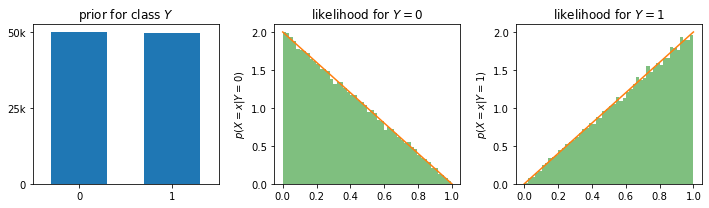

In [35]:
fig = plt.figure(figsize = (10,3))

plt.subplot(131)
plt.title(r'prior for class $Y$')
plt.bar([0,1],[X_0.size, X_1.size],width = 0.6)
plt.xticks([0,1])
plt.xlim([-0.5,1.5])
plt.yticks([0,25000,50000],['0','25k','50k'])

plt.subplot(132)
plt.title(r'likelihood for $Y=0$')
plt.hist(X_0,50,density=True,facecolor='green',alpha =0.5)
plt.ylabel(r'$p(X=x|Y=0)$')
plt.plot([0,1],[2,0])

plt.subplot(133)
plt.title(r'likelihood for $Y=1$')
plt.hist(X_1,50,density=True,facecolor='green',alpha =0.5)
plt.ylabel(r'$p(X=x|Y=1)$')
plt.plot([0,1],[0,2])

plt.tight_layout()

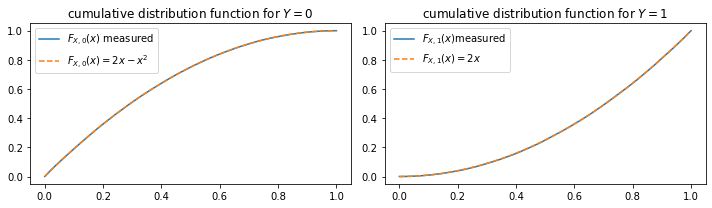

In [50]:
fig = plt.figure(figsize=(10,3))
domain = np.linspace(0,1,50)

plt.subplot(121)
plt.title(r'cumulative distribution function for $Y = 0$')
cdf_0 = np.array([np.count_nonzero(X_0<t) for t in domain],dtype = float)
cdf_0 /= cdf_0.max()

plt.plot(domain, cdf_0, label = r'$F_{X,0}(x)$ measured')
plt.plot(domain, 2*domain - np.square(domain), '--', label=r'$F_{X,0}(x) = 2x - x^2$')
plt.legend()

plt.subplot(122)
plt.title(r'cumulative distribution function for $Y = 1$')
cdf_1 = np.array([np.count_nonzero(X_1<t) for t in domain],dtype = float)
cdf_1 /= cdf_1.max()
plt.plot(domain,cdf_1,label = r'$F_{X,1}(x)$measured')
plt.plot(domain,np.square(domain),'--',label = r'$F_{X,1}(x)=2x$')
plt.legend()

plt.tight_layout()

# 1.2 Classification by Thresholding

In [61]:
def evaluate_classifier(M,run_count,classifier,create_data=create_data):#定义样本大小，每个样本大小测试次数，分类器，数据
    results = np.zeros(run_count)
    for i in range(run_count):
        data = create_data(M)
        wrong = 0
        for data_point in data:
            x,y_true = data_point
            y_pred = classifier(x)
            if y_pred != y_true:
                wrong += 1
        results[i] = wrong
        
    return results*100/M                

In [97]:
ts = [0.2,0.5,0.6]
Ms = [10,100,1000,10000]
run_count = 10
results_A = []
results_B = []
for t in ts:
    def pred_A(x): return 0 if x <= t else 1
    def pred_B(x): return 1 if x <= t else 0
    for M in Ms:
        error_rates_A = evaluate_classifier(M,run_count,pred_A)
        results_A.append({'$x_t$':t,'$M$':M,'mean':error_rates_A.mean(),'std':error_rates_A.std()})
        
        error_rates_B = evaluate_classifier(M,run_count,pred_B)
        results_B.append({'$x_t$':t,'$M$':M,'mean':error_rates_B.mean(),'std':error_rates_B.std()})

In [99]:
df_A = pd.DataFrame(results_A)
df_A = df_A.groupby(["$x_t$", "$M$"]).first().unstack()
df_A

mean                     std                  
$M$   10    100   1000  10000 10    100   1000  10000
$x_t$                                                
0.20  39.00 34.00 33.89 34.11 11.36  4.65  1.19  0.39
0.50  29.00 27.00 24.62 25.00 13.75  4.10  0.76  0.46
0.60  32.00 25.70 25.62 26.16 17.20  6.62  1.50  0.31

In [100]:
df_B = pd.DataFrame(results_B)
df_B = df_B.groupby(["$x_t$", "$M$"]).first().unstack()
df_B

mean                     std                  
$M$   10    100   1000  10000 10    100   1000  10000
$x_t$                                                
0.20  69.00 66.80 65.44 66.07 13.75  7.49  1.62  0.49
0.50  71.00 75.00 75.21 74.81 15.13  4.60  1.88  0.61
0.60  70.00 74.80 73.68 73.95 14.14  5.06  1.74  0.33

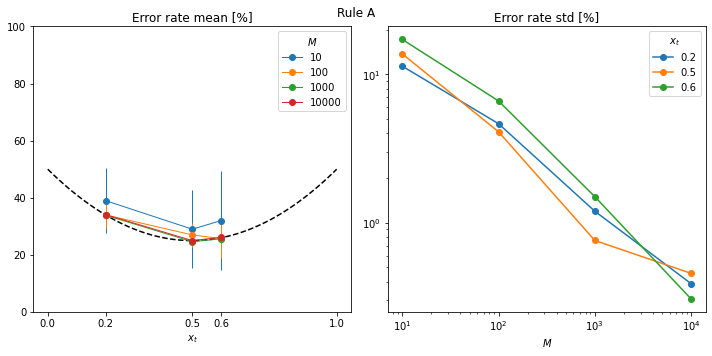

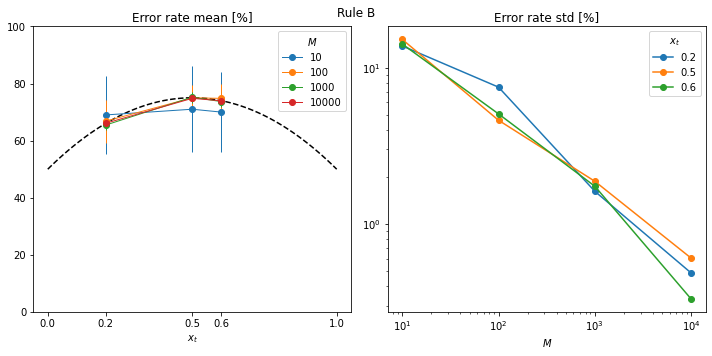

In [102]:
# Show true errors as comparison
def error_A(t): return 100 * (0.25 + np.square(t - 0.5))
def error_B(t): return 100 * (0.75 - np.square(t - 0.5))

continuous_ts = np.linspace(0, 1, 100)
for name, df, true_error in zip(["A", "B"], [df_A, df_B], [error_A, error_B]):
    # This creates two plots next to one another in a new figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    plt.suptitle(f"Rule {name}")
    
    # First plot: Error rate mean confirms true error
    plt.sca(ax1)
    plt.ylim(0, 100)
    plt.title("Error rate mean [%]")
    df["mean"].plot(marker="o", yerr=df["std"], lw=1, ax=ax1)
    plt.plot(continuous_ts, true_error(continuous_ts), "k--")
    plt.xticks([0] + ts + [1])
    
        # Second plot: Error rate std declines with more samples
    plt.sca(ax2)
    plt.title("Error rate std [%]")
    df["std"].T.plot(marker="o", ax=ax2, logx=True, logy=True)#T转置，log代表对数画图
    
    plt.tight_layout()

# 1.3 Baseline Classifiers

In [108]:
def pred_C(x): return np.random.randint(2)
def pred_D(x): return 1

def error_C(): return 50
def error_D(): return 50

results_C=[]
results_D=[]
for M in Ms:
    error_C=evaluate_classifier(M,run_count,pred_C)
    results_C.append({'$M$':M,'mean':error_C.mean(),'std':error_C.std()})
    
    error_D=evaluate_classifier(M,run_count,pred_D)
    results_D.append({'$M$':M,'mean':error_C.mean(),'std':error_D.std()})
    

In [129]:
df_C = pd.DataFrame(results_C)
df_C.set_index("$M$",inplace=True)
df_C

,mean,std
$M$,,
10,36.00,12.81
100,50.10,4.44
1000,50.97,1.40
10000,49.87,0.59


In [130]:
df_D = pd.DataFrame(results_D)
df_D.set_index('$M$',inplace=True)
df_D

,mean,std
$M$,,
10,36.00,16.73
100,50.10,4.20
1000,50.97,1.08
10000,49.87,0.54


Text(0.5, 1.0, 'Error for rule C & D')

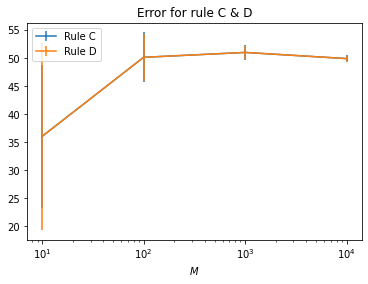

In [133]:
df_C.plot(y='mean',yerr='std',color="C0",logx=True,ax=plt.gca(),label='Rule C')
df_D.plot(y='mean',yerr='std',color="C1",logx=True,ax=plt.gca(),label='Rule D')
plt.title('Error for rule C & D')

# 1.4 Nearest Neighbor Classification

In [ ]:
def nn_classifier(x_test,x_train):
    '''
    测试集：测试模型推广能力
    训练集：训练模型
    '''
    
    